In [21]:
import os
import sys
from Bio import SeqIO
sys.path.append('utils')
import utils
import kanalyzer
import protein_score
import mutation_score
import discriminative_score

In [22]:
datasets = {
    "Severe_acute_respiratory_syndrome_coronavirus_2": {
        "k": 9,
        "taxon_id": 2697049,
        "input_file": "data/Severe_acute_respiratory_syndrome_coronavirus_2/Severe_acute_respiratory_syndrome_coronavirus_2_nucleotide_sequences.fasta",
        "output_folder": "data/Severe_acute_respiratory_syndrome_coronavirus_2/results",
        "infos_file": "data/Severe_acute_respiratory_syndrome_coronavirus_2/Severe_acute_respiratory_syndrome_coronavirus_2_infos.json",
        "aligner_matrix": "BLOSUM62",
        "aligner_open_gap_score": -10.0,
        "aligner_extend_gap_score": -2.0,
        "threshold": 25
    },
    "Human_immunodeficiency_virus_1": {
        "k": 9,
        "taxon_id": 388795,
        "input_file": "data/Human_immunodeficiency_virus_1/Human_immunodeficiency_virus_1_nucleotide_sequences.fasta",
        "output_folder": "data/Human_immunodeficiency_virus_1/results",
        "infos_file": "data/Human_immunodeficiency_virus_1/Human_immunodeficiency_virus_1_infos.json",
        "aligner_matrix": "BLOSUM62",
        "aligner_open_gap_score": -10.0,
        "aligner_extend_gap_score": -2.0,
        "threshold": 33
    },
    "US28": {
        "k": 9,
        "taxon_id": 10359, 
        "input_file": "data/Human_betaherpesvirus_5/US28/US28_nucleotide_sequences.fasta",
        "output_folder": "data/Human_betaherpesvirus_5/US28/results",
        "infos_file": "data/Human_betaherpesvirus_5/US28/US28_infos.json",
        "aligner_matrix": "BLOSUM62",
        "aligner_open_gap_score": -10.0,
        "aligner_extend_gap_score": -2.0,
        "threshold": 25
    },
    "UL55": {
        "k": 9,
        "taxon_id": 10359,
        "input_file": "data/Human_betaherpesvirus_5/UL55/UL55_nucleotide_sequences.fasta",
        "output_folder": "data/Human_betaherpesvirus_5/UL55/results",
        "infos_file": "data/Human_betaherpesvirus_5/UL55/UL55_infos.json",
        "aligner_matrix": "BLOSUM62",
        "aligner_open_gap_score": -10.0,
        "aligner_extend_gap_score": -2.0,
        "threshold": 25
    },
    "UL73": {
        "k": 9,
        "taxon_id": 10359,
        "input_file": "data/Human_betaherpesvirus_5/UL73/UL73_nucleotide_sequences.fasta",
        "output_folder": "data/Human_betaherpesvirus_5/UL73/results",
        "infos_file": "data/Human_betaherpesvirus_5/UL73/UL73_infos.json",
        "aligner_matrix": "BLOSUM62",
        "aligner_open_gap_score": -10.0,
        "aligner_extend_gap_score": -2.0,
        "threshold": 25
    }
}

In [23]:
def compile_results(results, threshold_percentage):
    """
    Compile results by aggregating variations and amino acid changes based on a threshold.

    Parameters:
    - results: Dict containing the analysis results from kanalyzer.
    - threshold_percentage: The threshold percentage to include variations.

    Returns:
    - compiled_results: Dict containing compiled variations and amino acid changes.
    """
    temp_variations = {}

    # Collect class counts and temporary variations data
    for gene, sequences in results.items():
        class_counts = {}
        temp_variations.setdefault(gene, {})
        
        for description, mutations in sequences.items():
            class_id = description.split('|')[-1]

            class_counts[class_id] = class_counts.get(class_id, 0) + 1

            for position_kmer, details in mutations.items():
                variation = details['variations']
                amino_acid_changes = details['amino_acid_changes']

                temp_variations[gene].setdefault(position_kmer, {})
                temp_variations[gene][position_kmer].setdefault(variation, {
                    'count': 0,
                    'amino_acid_changes': set(),
                    'class_specific_counts': {}
                })

                variation_info = temp_variations[gene][position_kmer][variation]
                variation_info['count'] += 1
                variation_info['amino_acid_changes'].update(amino_acid_changes)
                variation_info['class_specific_counts'][class_id] = variation_info['class_specific_counts'].get(class_id, 0) + 1

    compiled_results = {}
    # Compile results based on the threshold
    for gene, positions in temp_variations.items():
        compiled_results[gene] = {}
        for position_kmer, variations in positions.items():
            compiled_results[gene][position_kmer] = {
                'variations': set(),
                'amino_acid_changes': set()
            }
            for variation, info in variations.items():
                include_variation = False
                for class_id, count in info['class_specific_counts'].items():
                    total = class_counts[class_id]
                    if (count / total) * 100 >= threshold_percentage:
                        include_variation = True
                        break
                if include_variation:
                    compiled_results[gene][position_kmer]['variations'].add(variation)
                    compiled_results[gene][position_kmer]['amino_acid_changes'].update(info['amino_acid_changes'])
    return compiled_results

In [24]:
def compute_kss_scores(compiled_results, results, infos):
    """
    Compute k-mer significance scores (KSS) for compiled results.

    Parameters:
    - compiled_results: Dict containing compiled variations and amino acid changes.
    - results: Original results from kanalyzer.
    - infos: Dict containing additional information like taxon_id and output_folder.

    Returns:
    - compiled_results: Updated compiled_results with KSS scores.
    """
    for gene, data in compiled_results.items():
        mi = []
        fi = []
        rms = []
        # Update protein score in results
        ps = protein_score.get_protein_score(infos['taxon_id'], gene)
        for key, details in data.items():
            details['protein_score'] = ps

        # Evaluate gene-related scores
        y = [entry.split('|')[-1] for entry in results[gene].keys()]
        categorized_scores_dict = {}
        uncategorized_scores_dict = {}

        for key, details in data.items():
            amino_acid_changes = details['amino_acid_changes']
            mutational_scores = mutation_score.get_mutational_scores(
                amino_acid_changes, categorize=True
            )
            mutational_score = max(mutational_scores.values()) if mutational_scores else 0
            details['mutational_score'] = mutational_score

            X = []
            variations = details['variations']
            for entry_value in results[gene].values():
                variation_presence = [
                    1 if variation in entry_value.get(key, {}).get("variations", "")
                    else 0 for variation in variations
                ]
                X.append(variation_presence)
            
            if not X:
                continue  # Skip if X is empty

            categorized_scores, uncategorized_scores = discriminative_score.get_discriminative_scores(X, y)
            categorized_scores_dict[str(key)] = categorized_scores
            uncategorized_scores_dict[str(key)] = uncategorized_scores

            #####
            from sklearn.feature_selection import mutual_info_classif
            from sklearn.tree import DecisionTreeClassifier
            rms.append(uncategorized_scores[3])
            mi.append(sum(mutual_info_classif(X, y, random_state=42)))
            decisionTreeClassifier = DecisionTreeClassifier(random_state=42).fit(X, y)
            fi.append(sum(decisionTreeClassifier.feature_importances_))

            details['discriminative_score'] = categorized_scores[3]
            average_score = (
                details['discriminative_score'] +
                details['mutational_score'] +
                details['protein_score']
            ) / 3
            details['k_mer_significance_score'] = round(average_score, 1)

        # Save categorized and uncategorized scores
        output_folder = infos['output_folder']
        utils.save_data_as_json(
            categorized_scores_dict,
            os.path.join(output_folder, f"{gene}_categorized_scores.json")
        )
        utils.save_data_as_json(
            uncategorized_scores_dict,
            os.path.join(output_folder, f"{gene}_uncategorized_scores.json")
        )
        print('mi', mi)
        print('fi', fi)
        print('rms', rms)
    return compiled_results

In [25]:
# Main processing loop
for dataset, infos in datasets.items():
    print(f"\nProcessing: {dataset}")
    # Load configuration and input files
    threshold = infos['threshold']
    input_file = infos['input_file']
    output_folder = infos['output_folder']
    os.makedirs(output_folder, exist_ok=True)

    # Load all sequences once to avoid opening the file multiple times
    with open(input_file, "r") as file:
        records = list(SeqIO.parse(file, "fasta"))

    # Analyze records using kanalyzer
    results = kanalyzer.analyze_records(records, infos)

    # Save initial results
    results_file_path = os.path.join(output_folder, f"{dataset}_results.json")
    utils.save_data_as_json(results, results_file_path)
    print(f"Results saved to {results_file_path}")

    # Compile results and save
    compiled_results = compile_results(results, threshold)
    compiled_results = compute_kss_scores(compiled_results, results, infos)
    compiled_file_path = os.path.join(output_folder, f"{dataset}_compiled_results.json")
    utils.save_data_as_json(compiled_results, compiled_file_path)
    print(f"Compiled results saved to {compiled_file_path}")


Processing: Severe_acute_respiratory_syndrome_coronavirus_2
Results saved to data/Severe_acute_respiratory_syndrome_coronavirus_2/results\Severe_acute_respiratory_syndrome_coronavirus_2_results.json
mi [np.float64(0.010586669088798573), np.float64(0.021397393160049738), np.float64(0.013486501923354766), np.float64(0.011060918005848741), np.float64(0.009242912345408527), np.float64(0.01984946180874747), np.float64(0.010310762790861183), np.float64(0.012948113761415136), np.float64(0.012198248313199933), np.float64(0.009986852538143687), np.float64(0.009521896162034693), np.float64(0.008968578526034499), np.float64(0.011548228952043438), np.float64(0.009994174947061119), np.float64(0.012790511704848129), np.float64(0.70339895097759), np.float64(0.009515586872353765), np.float64(0.009872298646525834), np.float64(0.010310762790861183), np.float64(0.2658631883952012), np.float64(0.01054761483147626), np.float64(0.009493368073422381), np.float64(0.011105058947717517), np.float64(0.017696067

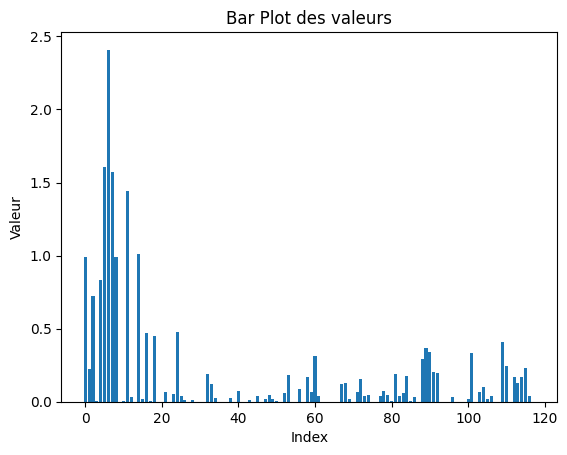

In [26]:
import numpy as np
import matplotlib.pyplot as plt
data = [np.float64(0.9928025254404131), np.float64(0.22704670219737721), np.float64(0.723712579203645), np.float64(0.006128718074592587), np.float64(0.8349923092287694), np.float64(1.6053896471340625), np.float64(2.408688641583053), np.float64(1.5689931955411427), np.float64(0.9902298159223184), np.int64(0), np.float64(0.0023560265180742057), np.float64(1.4419290086569396), np.float64(0.032148938542923666), np.float64(0.0009598140999518279), np.float64(1.0094095602173736), np.float64(0.020545600784299012), np.float64(0.46999533362094015), np.float64(0.005986581658911749), np.float64(0.44929931534363865), np.int64(0), np.int64(0), np.float64(0.06957246348772239), np.int64(0), np.float64(0.053079773595341884), np.float64(0.4774736814157716), np.float64(0.04221510892344371), np.float64(0.010200361948484726), np.int64(0), np.float64(0.008487767329890428), np.int64(0), np.int64(0), np.int64(0), np.float64(0.1902179174514793), np.float64(0.1216175557547774), np.float64(0.023444614959037047), np.int64(0), np.int64(0), np.int64(0), np.float64(0.02554777901878813), np.int64(0), np.float64(0.0700079903513573), np.int64(0), np.int64(0), np.float64(0.01117706057425405), np.int64(0), np.float64(0.03918905301210085), np.int64(0), np.float64(0.018191982747100433), np.float64(0.04548586964562373), np.float64(0.016748918830265414), np.float64(0.003506862834198099), np.int64(0), np.float64(0.05796005835896967), np.float64(0.18500669889387833), np.int64(0), np.int64(0), np.float64(0.09029426574660437), np.int64(0), np.float64(0.16625195271012094), np.float64(0.06599547775871395), np.float64(0.31000331332734987), np.float64(0.03660471327687409), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.float64(0.12465888380874723), np.float64(0.12814139978410788), np.float64(0.018348070659903737), np.int64(0), np.float64(0.06912873858059809), np.float64(0.15727818242933456), np.float64(0.03659064188337524), np.float64(0.04430012337899569), np.int64(0), np.int64(0), np.float64(0.04059046047800363), np.float64(0.0701599479725381), np.float64(0.04544915759684809), np.float64(0.006235355389322184), np.float64(0.18798511194495005), np.float64(0.03685850264540358), np.float64(0.06196361932268468), np.float64(0.17532102971230357), np.float64(0.007586183504497246), np.float64(0.03146380250439185), np.int64(0), np.float64(0.29364154422519473), np.float64(0.3676025697540455), np.float64(0.33934576284541285), np.float64(0.20223383777408577), np.float64(0.19381304157288737), np.int64(0), np.int64(0), np.int64(0), np.float64(0.033959929399783206), np.int64(0), np.int64(0), np.int64(0), np.float64(0.020310161256862358), np.float64(0.33145057469115047), np.int64(0), np.float64(0.06742271299701175), np.float64(0.10238666087137105), np.float64(0.02103197883993646), np.float64(0.03617087827387078), np.int64(0), np.int64(0), np.float64(0.4113135399006551), np.float64(0.2443352883968659), np.int64(0), np.float64(0.16623208760262953), np.float64(0.12506409322736767), np.float64(0.1672811673934098), np.float64(0.23159213370849896), np.float64(0.03954288679543039), np.int64(0)]


# Index pour le bar plot
x = np.arange(len(data))

# Création du bar plot
plt.bar(x, data)

# Ajout d'un titre et des labels des axes
plt.title("Bar Plot des valeurs")
plt.xlabel("Index")
plt.ylabel("Valeur")

# Affichage de la figure
plt.show()


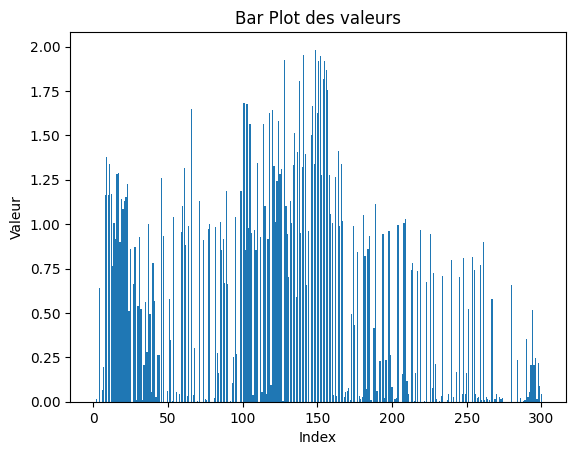

In [27]:
import numpy as np
import matplotlib.pyplot as plt
data = [np.int64(0), np.int64(0), np.float64(0.016856871312035615), np.int64(0), np.float64(0.6395252944736496), np.int64(0), np.float64(0.0675598608117336), np.float64(0.1932898333989228), np.float64(1.1635175671344011), np.float64(1.3780913717134329), np.float64(1.166940733104266), np.float64(1.336839023964304), np.float64(1.1682969858224854), np.float64(0.767164073287232), np.float64(1.0046020152581516), np.float64(0.9176744926129756), np.float64(1.2819723795087803), np.float64(1.290457356350421), np.float64(0.8981009812546115), np.float64(1.1412112714736182), np.float64(1.085731283536339), np.float64(1.1299203418358592), np.float64(1.1548421737969465), np.float64(1.2237627729276623), np.float64(0.5125422792952159), np.float64(0.8595143553994666), np.int64(0), np.float64(0.6605446987387971), np.float64(0.8716422244912534), np.float64(0.010236618245932139), np.float64(0.5394053174262969), np.float64(0.9303989660105085), np.float64(0.5230289545121869), np.float64(0.011795391072549677), np.float64(0.2057215743884484), np.float64(0.5587971505902243), np.float64(0.27941091659317574), np.float64(1.0026524585220327), np.float64(0.4959368374541977), np.float64(0.05408589687884868), np.float64(0.7789648460668479), np.float64(0.5650082521670972), np.float64(0.028309989671073676), np.float64(0.2639054163059711), np.float64(0.2626615824922858), np.int64(0), np.float64(1.2607249902596689), np.float64(0.9310944045323233), np.int64(0), np.int64(0), np.float64(0.061570476313754785), np.float64(0.5777868431147284), np.float64(0.3485448593467779), np.float64(0.003160314376309703), np.float64(1.039407493285535), np.int64(0), np.float64(0.056921940422037576), np.int64(0), np.float64(0.044088914512106836), np.float64(0.9531858922486212), np.float64(1.1008673133354072), np.float64(1.314533785149058), np.float64(0.8825250033351733), np.float64(0.03397041403432288), np.float64(0.9900983505600229), np.int64(0), np.float64(1.646394093280871), np.float64(0.0395495035389235), np.float64(0.302571790806647), np.int64(0), np.float64(0.0015407085869099113), np.float64(1.13047118247205), np.int64(0), np.int64(0), np.float64(0.9133866903828305), np.float64(0.013548552102448763), np.float64(0.01165867154102429), np.float64(0.9752518121823432), np.float64(1.0027176936195576), np.int64(0), np.float64(0.0007839802668447859), np.float64(0.02129163728817396), np.float64(0.982358092258593), np.float64(0.27217769273159687), np.float64(0.1600353226560709), np.float64(1.0107443447986801), np.float64(0.8562098937636438), np.float64(0.918167134922756), np.float64(0.6702613767399161), np.float64(1.1879506124627641), np.float64(0.6648546314579493), np.int64(0), np.float64(0.0016972300287760866), np.float64(0.10489840714060605), np.float64(0.2493395822239628), np.float64(1.0430335292528536), np.float64(0.2711876451292201), np.int64(0), np.int64(0), np.float64(1.1892040657467238), np.int64(0), np.float64(1.6831576293707065), np.float64(0.853665699945249), np.float64(1.674105595317497), np.float64(0.9769984709765529), np.float64(1.5635760128070522), np.float64(0.9503436606237416), np.float64(0.037511732885511684), np.float64(0.9665962562752648), np.float64(0.8546680580240877), np.float64(1.345754444782455), np.int64(0), np.float64(0.9273150625524114), np.float64(0.05616673295544761), np.float64(1.5640996491364951), np.float64(1.1021577481741105), np.float64(0.042096633384546056), np.float64(0.9149377624718005), np.float64(1.625796946370619), np.float64(0.09399338556441705), np.float64(1.6454023454124913), np.float64(1.327562832715154), np.float64(1.0098677899472785), np.float64(1.240390164881499), np.float64(1.5834961632073759), np.float64(1.2818720696900419), np.float64(1.3094089831293172), np.float64(0.003960117000248342), np.float64(1.9240782746285527), np.float64(1.103654677170114), np.float64(0.9472370574127604), np.float64(0.700521751852665), np.float64(1.128162805757559), np.float64(1.0081614950415971), np.float64(1.3352008321375013), np.float64(1.5116376106941751), np.float64(0.5880837504720846), np.float64(1.405561713218994), np.float64(1.8080180886604784), np.float64(0.9491366873759839), np.float64(1.3207205479012416), np.float64(1.951469672602513), np.float64(1.3964408285001113), np.float64(0.6599997046497097), np.float64(0.9609737481114276), np.int64(0), np.float64(1.5000857913732129), np.float64(1.66625365574467), np.float64(1.3362609761045123), np.float64(1.9823674438177543), np.float64(1.624521426202464), np.float64(1.9205519604138759), np.float64(1.948612514336008), np.float64(1.2787897229703218), np.float64(1.8195453539577517), np.float64(1.9189664160816648), np.float64(1.86654895441587), np.float64(1.7577691625775829), np.float64(1.2785301756026737), np.float64(1.0544901547190944), np.float64(1.0063611303792257), np.float64(0.03505837250861754), np.float64(1.26727358165918), np.float64(0.03397961963824159), np.float64(1.4147845075467151), np.float64(0.9918275931479255), np.float64(1.3403289283105395), np.float64(1.019820138214811), np.float64(0.027046953533184315), np.float64(0.05384853980953119), np.float64(0.05764606774225722), np.float64(0.07813589778765495), np.float64(0.01140851836546064), np.float64(0.495343958169322), np.float64(0.9900970948881715), np.float64(0.43068531878135086), np.int64(0), np.float64(0.844386365412668), np.float64(0.03203184881714938), np.float64(0.017100283137797767), np.float64(0.025720029097348718), np.float64(1.0490074408011043), np.float64(0.8202124277567666), np.float64(0.07185528068880709), np.float64(0.8620854856637388), np.float64(0.932936738599091), np.float64(0.00849579824629032), np.int64(0), np.float64(0.4152947306971517), np.float64(1.112799587006511), np.float64(0.05868210310720201), np.int64(0), np.float64(0.22970486112984823), np.int64(0), np.float64(0.9462083301432305), np.float64(0.018541012389238), np.float64(0.23630171940296862), np.int64(0), np.float64(0.961273975288456), np.float64(0.2613375498584145), np.float64(0.08063758268837029), np.int64(0), np.float64(0.01723503919966296), np.float64(0.021006964226572666), np.float64(0.9973074575428154), np.int64(0), np.int64(0), np.float64(0.15788426810175515), np.float64(1.0059274189728344), np.float64(1.0270350010044051), np.float64(0.1189322068455616), np.float64(0.04579100926006241), np.int64(0), np.float64(0.7405684817273279), np.float64(0.7789617558801343), np.float64(0.006661665974817765), np.float64(0.1636772545042211), np.float64(0.7344684591105559), np.int64(0), np.float64(0.966313331833069), np.int64(0), np.int64(0), np.float64(0.004372996222079095), np.float64(0.6719958297604061), np.int64(0), np.int64(0), np.float64(0.9443129287488579), np.float64(0.07711559675363011), np.float64(0.7276596756678799), np.float64(0.20997771491429962), np.float64(0.01392860928893569), np.int64(0), np.float64(0.003963457709834639), np.float64(0.032206921234674724), np.float64(0.706478333295202), np.int64(0), np.int64(0), np.float64(0.01201563892363433), np.float64(0.04362940531432269), np.int64(0), np.float64(0.800261732377576), np.float64(0.025793136321254462), np.int64(0), np.float64(0.16857282633928028), np.int64(0), np.float64(0.6999465325393006), np.int64(0), np.float64(0.0447185592244872), np.float64(0.8104339339746596), np.float64(0.044815117792584847), np.float64(0.16292792708538162), np.float64(0.523583933819534), np.int64(0), np.int64(0), np.float64(0.8160622944819025), np.float64(0.7395138046772287), np.float64(0.04504423214505415), np.float64(0.02319285737079646), np.float64(0.02532125494383619), np.float64(0.7724733172963916), np.float64(0.01197329037007222), np.float64(0.8978945685778872), np.float64(0.007465358805825328), np.float64(0.027801752285470993), np.float64(0.01391421559796413), np.float64(0.011684990727946154), np.int64(0), np.float64(0.5765890637581814), np.int64(0), np.float64(0.014287501822531468), np.float64(0.04120949024364995), np.float64(0.0006279428415219002), np.float64(0.02822191731757595), np.float64(0.01534375483754813), np.float64(0.019258916724639086), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.float64(0.6587283008819285), np.int64(0), np.int64(0), np.int64(0), np.float64(0.23730625254911009), np.int64(0), np.float64(0.021534909436910166), np.int64(0), np.float64(0.002677724175667251), np.float64(0.011708557656363805), np.float64(0.350928047516881), np.float64(0.02718876602348619), np.float64(0.05434183872716147), np.float64(0.2090790316157891), np.float64(0.5137535812463265), np.float64(0.20842581340283184), np.float64(0.2443203303130046), np.float64(0.017284934168617205), np.float64(0.21794102395564652), np.float64(0.09056111908791964), np.float64(0.04186297525427207), np.int64(0)]


# Index pour le bar plot
x = np.arange(len(data))

# Création du bar plot
plt.bar(x, data)

# Ajout d'un titre et des labels des axes
plt.title("Bar Plot des valeurs")
plt.xlabel("Index")
plt.ylabel("Valeur")

# Affichage de la figure
plt.show()


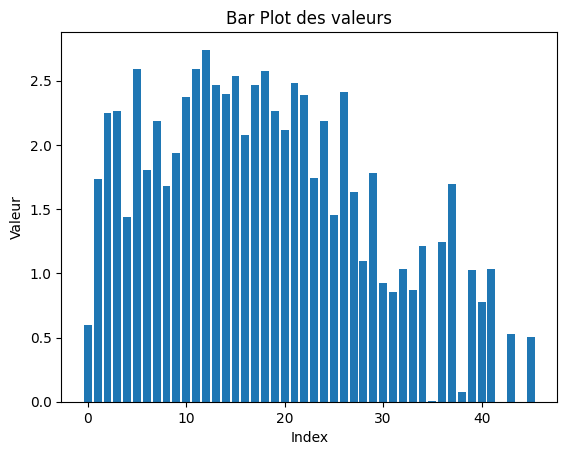

In [28]:
import numpy as np
import matplotlib.pyplot as plt
data = [np.float64(0.5996752994158809), np.float64(1.7314775799301545), np.float64(2.2464088188745435), np.float64(2.26191183455673), np.float64(1.4425606953956094), np.float64(2.5885917139792105), np.float64(1.8077934534990758), np.float64(2.189438374137642), np.float64(1.6783057065375595), np.float64(1.9368905223913648), np.float64(2.372790449918022), np.float64(2.5905551386972774), np.float64(2.7419310055019417), np.float64(2.4658895306198305), np.float64(2.3964379510594522), np.float64(2.535056033030524), np.float64(2.081347903087608), np.float64(2.465390929734724), np.float64(2.572595614571711), np.float64(2.265376647005486), np.float64(2.1139753312580747), np.float64(2.48177080004225), np.float64(2.3919323185322257), np.float64(1.7389448794660471), np.float64(2.185375482272858), np.float64(1.4547172854740813), np.float64(2.4095254369023795), np.float64(1.6330517899389818), np.float64(1.0995450446158115), np.float64(1.7821520329196012), np.float64(0.9274786136345634), np.float64(0.8571858426500616), np.float64(1.0302503558069769), np.float64(0.8733373842817711), np.float64(1.211161306492802), np.float64(0.0033274094699975443), np.float64(1.2452089049809008), np.float64(1.6994623984381323), np.float64(0.0734027096658667), np.float64(1.0245938040256157), np.float64(0.7733953428921776), np.float64(1.034692707861844), np.int64(0), np.float64(0.5311013628324606), np.int64(0), np.float64(0.5007817208039524)]


# Index pour le bar plot
x = np.arange(len(data))

# Création du bar plot
plt.bar(x, data)

# Ajout d'un titre et des labels des axes
plt.title("Bar Plot des valeurs")
plt.xlabel("Index")
plt.ylabel("Valeur")

# Affichage de la figure
plt.show()